### DSPT6 - Adding Data Science to a Web Application

The purpose of this notebook is to demonstrate:
- Simple online analysis of data from a user of the Twitoff app or an API
- Train a more complicated offline model, and serialize the results for online use

In [1]:
import os
import sqlite3
import pickle
import pandas as pd

In [2]:
# Connect to sqlite database
# conn = sqlite3.connect('C:\\Users\\Adam Carter\\Downloads\\lecture\\twitoff.sqlite3')

basedir = os.path.abspath(os.path.dirname("../twitoff/"))
path = os.path.join(basedir, 'twitoff.db')
# print(path)
# path = 'sqlite:///C:\\Projects\\twitoff\\twitoff\\twitoff.db'
conn = sqlite3.connect(path)

In [3]:
def get_data(query, conn):
    '''Function to get data from SQLite DB'''
    
    cursor = conn.cursor()
    result = cursor.execute(query).fetchall()

    # Get columns from cursor object
    columns = list(map(lambda x: x[0], cursor.description))

    # Assign to DataFrame
    df = pd.DataFrame(data=result, columns=columns)
    return df

In [4]:
import pickle

username_query = """
SELECT 
	tweet.id,
	tweet.text, 
	tweet.embedding,
	user.username
FROM tweet
JOIN user 
ON tweet.user_id = user.id;
"""

df = get_data(username_query, conn)
print(df.shape)
df['embedding_decoded'] = df.embedding.apply(lambda x: pickle.loads(x))
df.head(2)

(597, 4)


,id,text,embedding,username,embedding_decoded
0,669111829205938177,The rarest of beasts - a used rocket. Controll...,b'\x80\x05\x95$\x05\x00\x00\x00\x00\x00\x00\x8...,jeffbezos,"[-0.0891486, 0.12521237, -0.1862246, -0.056690..."
1,671461815210139648,"Breakthrough Energy Coalition. When in a box, ...",b'\x80\x05\x95$\x05\x00\x00\x00\x00\x00\x00\x8...,jeffbezos,"[-0.048133034, 0.19431339, -0.06864032, -0.053..."


In [5]:
pickle.loads(df.embedding.iloc[0])

array([-8.91486034e-02,  1.25212371e-01, -1.86224595e-01, -5.66906631e-02,
        3.11362520e-02,  2.48414446e-02, -6.93976283e-02, -1.03705101e-01,
       -6.72429726e-02,  1.80039442e+00, -1.39416397e-01,  6.52636364e-02,
        8.03948492e-02, -4.97721881e-02, -2.09537059e-01, -1.16369784e-01,
       -9.67616439e-02,  1.19802141e+00, -1.97275430e-01, -5.33693582e-02,
       -7.59659186e-02,  3.53720374e-02, -5.90171628e-02, -9.17383507e-02,
       -4.78082262e-02,  6.86318949e-02,  2.01813672e-02, -1.33606613e-01,
        1.23979859e-01, -1.49053365e-01, -7.85358250e-03,  4.75163907e-02,
       -4.19878736e-02,  1.06230073e-01,  7.15249106e-02, -4.56451625e-02,
        5.01714386e-02,  1.12095892e-01, -4.28963639e-02, -3.37880738e-02,
       -1.06627144e-01,  5.82183376e-02,  1.03460504e-02, -1.11458644e-01,
        7.96517357e-02,  6.22762218e-02, -1.81307763e-01,  4.43422161e-02,
        1.70267392e-02,  8.70617107e-02, -5.27961962e-02,  6.40502647e-02,
        8.46343767e-03,  

In [6]:
df.username.value_counts()

jeffbezos     226
TechCrunch    193
jackblack     161
elonmusk       17
Name: username, dtype: int64

In [7]:
import numpy as np

user1_embeddings = df.embedding_decoded[df.username == 'elonmusk']
user2_embeddings = df.embedding_decoded[df.username == 'jackblack']
embeddings = pd.concat([user1_embeddings, user2_embeddings])

embeddings_df = pd.DataFrame(embeddings.tolist(), 
                             columns=[f'dom{i}' for i in range(300)])

labels = np.concatenate([np.ones(len(user1_embeddings)),
                         np.zeros(len(user2_embeddings))])

print(embeddings_df.shape, labels.shape)

(178, 300) (178,)


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    embeddings_df,
    labels,
    test_size=0.25,
    random_state=42)

print(X_train.shape, X_test.shape)

(133, 300) (45, 300)


In [9]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [10]:
from sklearn.metrics import classification_report, plot_confusion_matrix

y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        41
         1.0       1.00      1.00      1.00         4

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



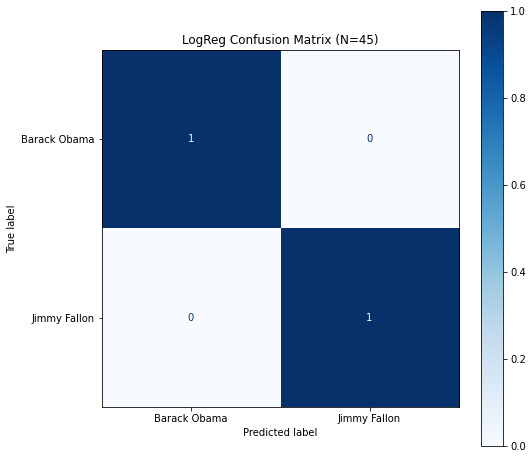

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(log_reg, X_test, y_test, 
                      normalize='true', cmap='Blues', 
                      display_labels=['Barack Obama', 'Jimmy Fallon'], ax=ax)
plt.title(f'LogReg Confusion Matrix (N={X_test.shape[0]})');

In [12]:
import spacy

nlp = spacy.load("en_core_web_md", disable=["tagger", "parser"])

def vectorize_tweet(nlp, tweet_text ):
    return list(nlp(tweet_text).vector)

In [13]:
new_embedding = vectorize_tweet(nlp, "The innovation displayed during this pandemic is unprecedented")
new_embedding[0:5]

[-0.12741038, 0.28394625, 0.209937, -0.03447726, -0.08926687]

In [14]:
log_reg.predict([new_embedding])

array([0.])

In [15]:
fname = "../models/logreg.pkl"
pickle.dump(log_reg, open(fname, "wb"))

In [16]:
unpickled_lr = pickle.load(open(fname, "rb"))

In [17]:
log_reg.predict([new_embedding])

array([0.])